<a href="https://colab.research.google.com/github/rcmckee/dsi-Capstone/blob/master/Patent_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import scipy.stats as scs
import statsmodels.api as sm
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [3]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials


    100% |████████████████████████████████| 993kB 14.2MB/s 


In [0]:
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
downloaded = drive.CreateFile({'id':'1UcoQDxQe5MGruMUoD4013HrTz346OH8i'}) 
downloaded.GetContentFile('small_700_through_710_descr_clm_code.csv')  
df = pd.read_csv('small_700_through_710_descr_clm_code.csv')
# Dataset is now stored in a Pandas Dataframe


In [14]:
df.head()

,Unnamed: 0,descr,clm,code
0,0,This application claims priority under 35 U.S....,What is claimed is: \n \n 1 . A pr...,700
1,1,BACKGROUND \n 1. Field of Invention \n ...,What is claimed is: \n \n 1 . A st...,700
2,2,CROSS-REFERENCE TO RELATED APPLICATIONS \n ...,What is claimed is: \n \n 1 . A me...,700
3,3,FIELD OF THE INVENTION \n The present inve...,1 . A method for state-transition-controlled p...,700
4,4,RELATED APPLICATION \n This application cl...,What is claimed is: \n \n 1 . A me...,700


In [15]:
df.drop('Unnamed: 0',axis=1, inplace=True)
df = df[(df['code']==705)|(df['code']==706)|(df['code']==700)]
df['descr_clm'] = df.descr + df.clm
df.drop(['descr','clm'],axis=1, inplace=True)
df['code'] = df['code'].astype('category')
df.head()

,code,descr_clm
0,700,This application claims priority under 35 U.S....
1,700,BACKGROUND \n 1. Field of Invention \n ...
2,700,CROSS-REFERENCE TO RELATED APPLICATIONS \n ...
3,700,FIELD OF THE INVENTION \n The present inve...
4,700,RELATED APPLICATION \n This application cl...


# Data exploration

In [16]:
df['code'].value_counts()

706    1000
705    1000
700    1000
Name: code, dtype: int64

In [0]:
df['category_id'] = df['code'].factorize()[0]

In [18]:
df['category_id'].value_counts()

1    1000
2    1000
0    1000
Name: category_id, dtype: int64

In [0]:
category_id_df = df[['code', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'code']].values)

In [20]:
id_to_category

{0: 700, 1: 705, 2: 706}

In [21]:
df.sample(5, random_state=0)

,code,descr_clm,category_id
2077,700,CROSS-REFERENCE TO RELATED APPLICATION(S) \n ...,0
3401,706,BACKGROUND \n Many systems are instrumente...,2
4393,706,FIELD \n The subject matter disclosed here...,2
10648,705,This application is a continuation of U.S. pat...,1
10687,705,BACKGROUND \n 1. Technical Field \n Em...,1


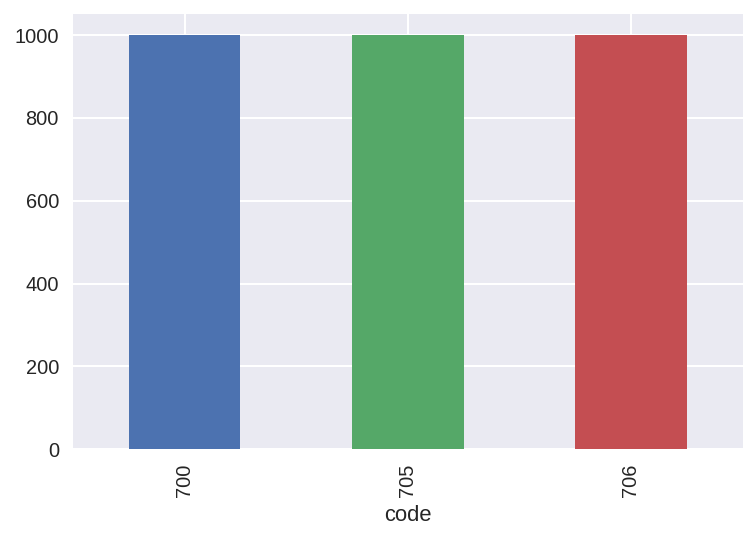

In [22]:
df.groupby('code').descr_clm.count().plot.bar(ylim=0);

# Tf-idf Vectorizer

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')

features = tfidf.fit_transform(df['descr_clm']).toarray()
labels = df['category_id']
features.shape

(3000, 110325)

**3000 applications, represented by 110325 features, representing the tf-idf score for different unigrams and bigrams.**

# Top 10 Uni-Grams and Bi-Grams for each Patent class

In [0]:
from sklearn.feature_selection import chi2

In [26]:
N = 10
for code, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(code))
  print("  . Most correlated unigrams:\n       . {}".format('\n       . '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n       . {}".format('\n       . '.join(bigrams[-N:])))

# '700':
  . Most correlated unigrams:
       . temperature
       . direction
       . motor
       . position
       . sensor
       . controlling
       . power
       . robot
       . control
       . controller
  . Most correlated bigrams:
       . electric power
       . control signal
       . robot according
       . power supply
       . control method
       . method controlling
       . controller configured
       . control unit
       . perspective view
       . control device
# '705':
  . Most correlated unigrams:
       . card
       . price
       . sale
       . financial
       . transactions
       . credit
       . purchase
       . merchant
       . transaction
       . payment
  . Most correlated bigrams:
       . debit card
       . financial transaction
       . account number
       . payment transaction
       . mobile device
       . account associated
       . goods services
       . service provider
       . credit card
       . point sale
# '706':
  . Most

# Model training and evaluation

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score

In [70]:
models = [
    RandomForestClassifier(n_estimators=400, max_depth=50, random_state=0),
    MultinomialNB(alpha=0.01),
    LogisticRegression(random_state=0, C=0.9),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed

In [0]:
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


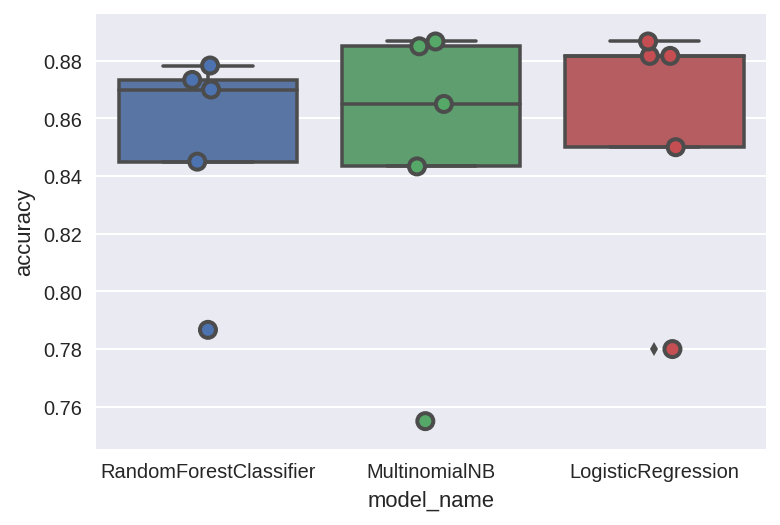

In [71]:
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2);

In [72]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LogisticRegression        0.856000
MultinomialNB             0.847000
RandomForestClassifier    0.850667
Name: accuracy, dtype: float64

#  LogisticRegression Model Interpretation 

In [0]:
from sklearn.model_selection import train_test_split

In [81]:
model = LogisticRegression(random_state=0, C=0.9)

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0, stratify=df['code'])

model.fit(X_train, y_train)
y_pred_proba = model.predict_proba(X_test)
y_pred = model.predict(X_test)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [82]:
y_train.value_counts()

2    670
1    670
0    670
Name: category_id, dtype: int64

In [83]:
y_test.value_counts()

2    330
1    330
0    330
Name: category_id, dtype: int64

In [0]:

from sklearn.metrics import confusion_matrix

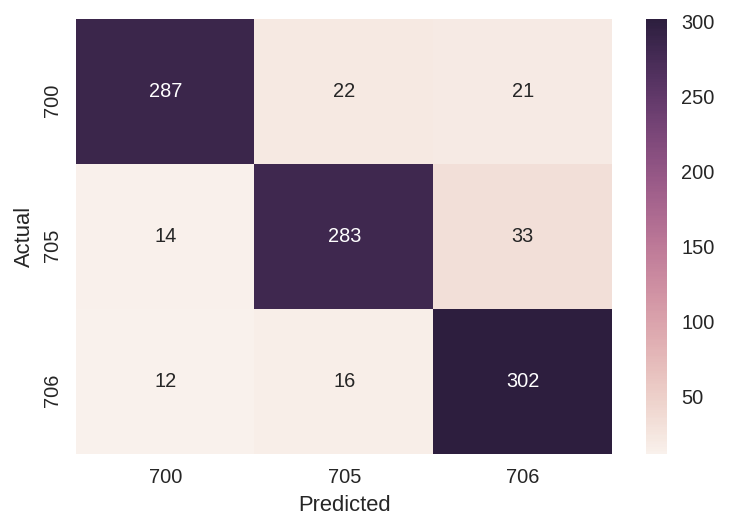

In [84]:
conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.code.values, yticklabels=category_id_df.code.values)
plt.ylabel('Actual')
plt.xlabel('Predicted');

## Analyze incorrectly labeled data

In [85]:
from IPython.display import display

for predicted in category_id_df.category_id:
  for actual in category_id_df.category_id:
    if predicted != actual and conf_mat[actual, predicted] >= 2:
      print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], id_to_category[predicted], conf_mat[actual, predicted]))
      display(df.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['descr_clm']])
      print('')

'705' predicted as '700' : 14 examples.


,descr_clm
1902,CROSS-REFERENCE TO RELATED APPLICATIONS \n ...
10656,TECHNICAL FIELD \n The present invention r...
558,CROSS-REFERENCES TO RELATED APPLICATIONS \n ...
532,CROSS-REFERENCE TO RELATED PATENT APPLICATION ...
1896,CROSS REFERENCE TO RELATED APPLICATIONS \n ...
2345,FIELD OF THE INVENTION \n Embodiments gene...
2378,BACKGROUND OF THE INVENTION \n 1. Field of...
7992,CROSS-REFERENCE TO RELATED APPLICATIONS \n ...
4298,CROSS-REFERENCE TO RELATED APPLICATIONS \n ...
1872,This application claims priority to U.S. Provi...



'706' predicted as '700' : 12 examples.


,descr_clm
4704,CROSS-REFERENCE TO RELATED APPLICATIONS \n ...
2572,CROSS-REFERENCE TO RELATED APPLICATIONS \n ...
3105,BACKGROUND \n Earth formations may be used...
4630,CROSS-REFERENCES TO RELATED APPLICATIONS \n ...
3356,RELATED APPLICATION INFORMATION \n This ap...
3360,BACKGROUND OF INVENTION \n 1. Field of the...
4373,RELATED APPLICATION INFORMATION \n The pre...
3345,CLAIM FOR PRIORITY \n This application cla...
4481,RELATED APPLICATIONS \n This application c...
4607,CROSS REFERENCE TO RELATED APPLICATIONS \n ...



'700' predicted as '705' : 22 examples.


,descr_clm
3972,This application claims the benefit of U.S. pr...
743,CROSS REFERENCE TO RELATED APPLICATIONS \n ...
3707,CROSS REFERENCE TO RELATED APPLICATIONS \n ...
3850,This application claims the benefit of U.S. Pr...
757,CROSS-REFERENCE TO RELATED APPLICATIONS \n ...
3706,BACKGROUND \n Shipments of items are often...
3694,CROSS REFERENCE TO RELATED APPLICATIONS \n ...
6112,CROSS-REFERENCE TO RELATED APPLICATIONS \n ...
3748,CLAIM OF BENEFIT TO PRIOR APPLICATION \n T...
3761,CROSS REFERENCE TO RELATED APPLICATIONS \n ...



'706' predicted as '705' : 16 examples.


,descr_clm
3181,RELATED APPLICATIONS \n This application i...
3404,CLAIM OF PRIORITY \n This application clai...
3354,CROSS-REFERENCE TO RELATED APPLICATIONS \n ...
3176,BACKGROUND \n 1. Field \n The system a...
4693,CROSS-REFERENCE TO RELATED APPLICATIONS \n ...
3099,CROSS-REFERENCE TO RELATED APPLICATIONS \n ...
4430,FIELD OF THE DISCLOSURE \n The present dis...
3298,CROSS-REFERENCE TO RELATED APPLICATIONS \n ...
3304,CROSS-REFERENCE TO RELATED APPLICATIONS \n ...
3287,CONTINUATION-IN-PART \n This application i...



'700' predicted as '706' : 21 examples.


,descr_clm
5227,RELATED APPLICATIONS \n This application c...
784,TECHNICAL FIELD \n The present disclosure ...
2076,CLAIM OF PRIORITY \n This application is a...
2092,CROSS REFERENCE TO RELATED APPLICATIONS \n ...
2117,CROSS-REFERENCE TO RELATED APPLICATIONS \n ...
2090,CROSS-REFERENCE TO RELATED APPLICATIONS \n ...
2107,CROSS REFERENCE TO RELATED APPLICATION \n ...
5312,FIELD OF THE INVENTION \n This description...
5318,RELATED APPLICATIONS \n This application c...
2036,FIELD \n Embodiments taught herein relate ...



'705' predicted as '706' : 33 examples.


,descr_clm
7101,CROSS-REFERENCE TO RELATED APPLICATIONS \n ...
10682,BACKGROUND \n Advertisers increasingly see...
7030,This application is a continuation of U.S. Ser...
7113,BACKGROUND \n Product lifecycle management...
7095,FIELD OF THE INVENTION \n The present inve...
8074,RELATED APPLICATIONS \n This application i...
8069,TECHNICAL FIELD \n The present disclosure ...
10624,FIELD OF THE INVENTION \n The invention re...
7029,TECHNICAL FIELD \n Embodiments of the pres...
7039,CLAIM OF PRIORITY \n This application is a...


In [86]:
# model.fit(features, labels)
from sklearn.feature_selection import chi2

N = 10
for category, category_id in sorted(category_to_id.items()):
  indices = np.argsort(model.coef_[category_id])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
  bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
  print("# '{}':".format(category))
  print("  . Top unigrams:\n       . {}".format('\n       . '.join(unigrams)))
  print("  . Top bigrams:\n       . {}".format('\n       . '.join(bigrams)))

# '700':
  . Top unigrams:
       . control
       . controller
       . power
       . controlling
       . sensor
       . robot
       . temperature
       . position
       . energy
       . controlled
  . Top bigrams:
       . control device
       . control unit
       . controller configured
       . perspective view
       . method controlling
       . control signal
       . control method
       . power supply
       . configured control
       . according claim
# '705':
  . Top unigrams:
       . payment
       . transaction
       . price
       . financial
       . customer
       . provider
       . purchase
       . transactions
       . account
       . sale
  . Top bigrams:
       . service provider
       . mobile device
       . point sale
       . credit card
       . method claim
       . implemented method
       . goods services
       . readable medium
       . account associated
       . computer executable
# '706':
  . Top unigrams:
       . learning
       . 

### Do phrases appear in 706 and 705?

In [87]:
df[df.descr_clm.str.lower().str.contains('machine learning')].code.value_counts()

706    178
705     17
700      8
Name: code, dtype: int64

In [88]:
df[df.descr_clm.str.lower().str.contains('linear regression')].code.value_counts()

706    32
700     7
705     6
Name: code, dtype: int64

In [89]:
df[df.descr_clm.str.lower().str.contains('statistical analysis')].code.value_counts()

706    32
700    11
705     7
Name: code, dtype: int64

In [90]:
df[df.descr_clm.str.lower().str.contains('statistics')].code.value_counts()

706    86
705    50
700    11
Name: code, dtype: int64

In [91]:
df[df.descr_clm.str.lower().str.contains('probability')].code.value_counts()

706    270
705     58
700     44
Name: code, dtype: int64

**Statistics and probability appear in both 706 and 705, meaning, there is possible opportunity to describe those processes in a different way so that it is read as a machine learning patent application instead of a business method patent (high risk of Alice rejection).**

# Test model on new patent application

In [94]:
#@title Default title text
texts = "1. A system comprising:a memory that stores computer executable components a processor that executes computer executable components stored in the memory wherein the computer executable components comprise:a snapshot component that generates a first sequence of multi-dimensional time series data and a second sequence of multi-dimensional time series data from multi-dimensional time series data associated with at least two different data types generated by a data system over a consecutive period of time and a machine learning component that analyzes the first sequence of multi-dimensional time series data and the second sequence of multi-dimensional time series data using a convolutional neuralnetwork system to predict an event associated with the multi-dimensional time series data. 2. The system of claim 1 wherein the snapshot component generates a data matrix associated with the first sequence of multi-dimensional time series data and the second sequence of multi-dimensional time series data and wherein the machine learning component analyzes the data matrix using the convolutional neural network system. 3. The system of claim 1 wherein the machine learning component analyzes the first sequence of multi-dimensional time series data and the second sequence of multi-dimensional time series data using a parallel network of processing units associated with the convolutional neural network system and wherein performance of the processor to predict the event associated with the multi-dimensional time series data is improved by employing the convolutional neural network system. 4. The system of claim 1 wherein the snapshot component determines a size of the first sequence of multi-dimensional time series data and the second sequence of multi-dimensional time series data based on data associated with the convolutional neural network system. 5. The system of claim 1 wherein the snapshot component determines a set of parameters for the convolutional neuralnetwork system based on a classification of data associated with the convolutional neural network system. 6. The system of claim 1 wherein a portion of data from the first sequence of multi-dimensional time series data corresponds to the second sequence of multi-dimensional time series data and wherein the machine learning component analyzes the portion of the data. 7. The system of claim 1 wherein at least the first sequence of multi-dimensional time series data comprises dynamic data that is related to other data included in the first sequence of multi-dimensional time series data or the second sequence of multi-dimensional time series data and wherein the machine learning component analyzes the dynamic data. 8. The system of claim 1 wherein the snapshot component generates the first sequence of multi-dimensional time series data and the second sequence of multi-dimensional time series data based on feedback data indicative of information for tuning the first sequence of multi-dimensional time series data and the second sequence of multi-dimensional time series data. 9. The system of claim 1 wherein the machine learning component adjusts the convolutional neural network system based on feedback data indicative of information for tuning the convolutional neural network system. 10. The system of claim 1 wherein the convolutional neuralnetwork system is associated with nonlinear processing of features associated with the first sequence of multi-dimensional time series data and the second sequence of multi-dimensional time series data. 11. The system of claim 1 further comprising:a display component that generates a user interface to display output data associated with the event in a human interpretable format. 12-19. (canceled) 20. A computer program product for machine learning the computer program product comprising a computer readable storage medium having program instructions embodied therewith the program instructions executable by processor to cause the processor to:generate by the processor a data matrix based on first time series data associated with a first data source and second time series data associated with a second data source analyze by the processor the data matrix associated with the first time series data and the second time series data using a convolutional neural network system and generate by the processor prediction data that comprises a predicted event associated with the first time series data and the second time series data based on data generated by the convolutional neural network system. 21. The computer program product of claim 20 wherein the program instructions are further executable by the processor to cause the processor to:modify by the processor the data matrix based on the data generated by the convolutional neural network system. 22. The computer program product of claim 20 wherein the program instructions are further executable by the processor to cause the processor to:modify by the processor a convolutional neural networkassociated with the convolutional neural network system based on the data generated by the convolutional neuralnetwork system. 23. A computer program product for machine learning the computer program product comprising a computer readable storage medium having program instructions embodied therewith the program instructions executable by processor to cause the processor to:generate by the processor a data matrix based on multi-dimensional time series data associated with at least two different data types perform by the processor a convolutional neural network process based on the data matrix associated with the multi-dimensional time series data and generate by the processor prediction data that comprises a predicted event associated with the multi-dimensional time series data based on the convolutional neural network process. 24. The computer program product of claim 23 wherein the program instructions are further executable by the processor to cause the processor to:modify by the processor the data matrix based on the prediction data. 25. The computer program product of claim 23 wherein the program instructions are further executable by the processor to cause the processor to:modify by the processor a convolutional neural networkassociated with the convolutional neural network process based on the prediction data.\"" #@param {type:"string"}
texts = [texts]
# text from patent https://patentimages.storage.googleapis.com/e2/3f/75/2f32412145e159/US20180260697A1.pdf

text_features = tfidf.transform(texts)
predictions = model.predict(text_features)
for text, predicted in zip(texts, predictions):
  print("  - Predicted as: '{}'".format(id_to_category[predicted]))
  print("")
  print('"{}"'.format(text))

  - Predicted as: '706'

"1. A system comprising:a memory that stores computer executable components a processor that executes computer executable components stored in the memory wherein the computer executable components comprise:a snapshot component that generates a first sequence of multi-dimensional time series data and a second sequence of multi-dimensional time series data from multi-dimensional time series data associated with at least two different data types generated by a data system over a consecutive period of time and a machine learning component that analyzes the first sequence of multi-dimensional time series data and the second sequence of multi-dimensional time series data using a convolutional neuralnetwork system to predict an event associated with the multi-dimensional time series data. 2. The system of claim 1 wherein the snapshot component generates a data matrix associated with the first sequence of multi-dimensional time series data and the second sequence of mu